### Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle


### Importando base de dados

In [19]:
#load data from txt file with no head witch the data is splot by :::
data = pd.read_table('Classification_Dataset/train_data.txt', sep=':::', engine='python',header=None)
#remove index 
data = data.drop([0], axis=1)
#set dataframe head 
data.columns = ['name', 'genre','description']

### ETL

In [20]:
#removing whitespaces from the start and end of the colum "genre"
data['genre'] = data['genre'].str.strip()

In [21]:
print("before filtering genres: ",len(data))
filter_list = ['drama', 'comedy', 'horror', 'thriller', 'action', 'mystery', 'sci-fi', 'fantasy', 'western', 'romance', 'music']
data = data[data['genre'].isin(filter_list)]
print("after filtering genres: ",len(data))

before filtering genres:  54214
after filtering genres:  29894


In [22]:
#creating a "super-genre" out of "horror", "thriller" and "mystery" 
data['genre'] = data['genre'].replace(['horror', 'thriller', 'mystery'], 'h-t-m')

#creating a "super-genre" out of "sci-fi" and "fantasy"
data['genre'] = data['genre'].replace(['sci-fi', 'fantasy'], 's-f')

#reindex data
data = data.reset_index(drop=True)


In [20]:
#removendo possiveis valores nulos de descrição
data = data[data['description'].notna()]

### EDA

<AxesSubplot:title={'center':'Number of movies in each genre'}>

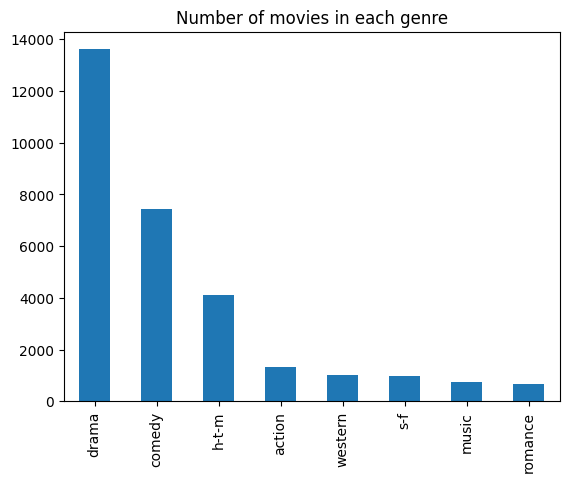

In [23]:
#ploting the number of movies in each genre
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre')

### Construção da Matriz TF-IDF

In [22]:
import nltk
from nltk import word_tokenize
import string
import unidecode
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')


listStringTerms = []


def criandoLinha(descrição):
    #capturando tokens da descrição
    tokens = word_tokenize(descrição)
    #normalizando para minúsculo
    tokens = [w.lower() for w in tokens]


    #removendo simbolos de pontuação
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]



    #tratando caracteres especiais
    tokens = [unidecode.unidecode(w) for w in tokens]

    #selecionando apenas palavras
    words = [word for word in tokens if word.isalpha()]

    #removendo palavras com 3 ou menos caracteres
    words = [word for word in words if len(word) > 3]
    
    #removendo palavras vazias
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]


    #redução de palavras
    porter = PorterStemmer()
    stemmedWords = [porter.stem(word) for word in words] 

    #transformando lista de stemmedWords em uma string
    stringTerms = ' '.join(stemmedWords)



    return stringTerms



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lorenzo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/lorenzo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:

#criando a lista de strings de termos
listStringTerms = data['description'].apply(criandoLinha)
##construindo matriz TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(listStringTerms)


In [22]:
#save X and y in a file
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

In [4]:
X = pickle.load(open('X.pickle', 'rb'))

In [17]:
#do PCA for esparce matrix
from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
# X = svd.fit_transform(X)
u, s, v = np.linalg.svd(X, full_matrices=False)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [12]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=600, random_state=3)
X_svd = svd.fit_transform(X)

In [13]:
svd.explained_variance_ratio_.sum()

0.2745002936757809

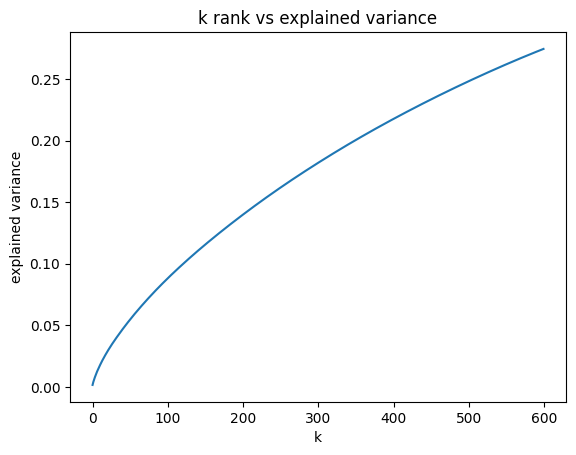

In [14]:
#plot k rank vs explained variance
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('k')
plt.ylabel('explained variance')
plt.title('k rank vs explained variance')
plt.show()


In [ ]:
data['genre']

## Agrupamento

<AxesSubplot:title={'center':'Number of movies in each genre'}>

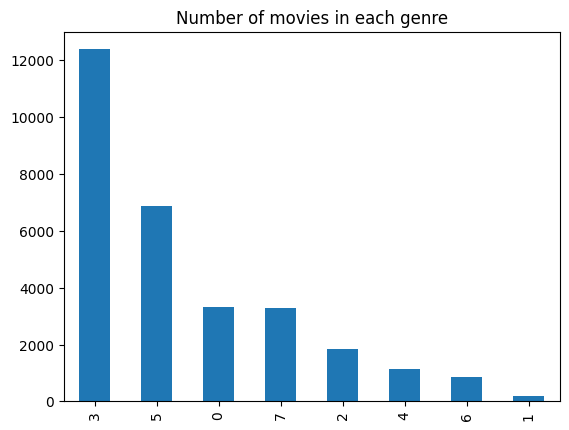

In [15]:
#k neighbors classifier for X_svd
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=45).fit(X_svd)
y_kmeans = kmeans.predict(X_svd)

#ploting the number of movies in each genre
pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')




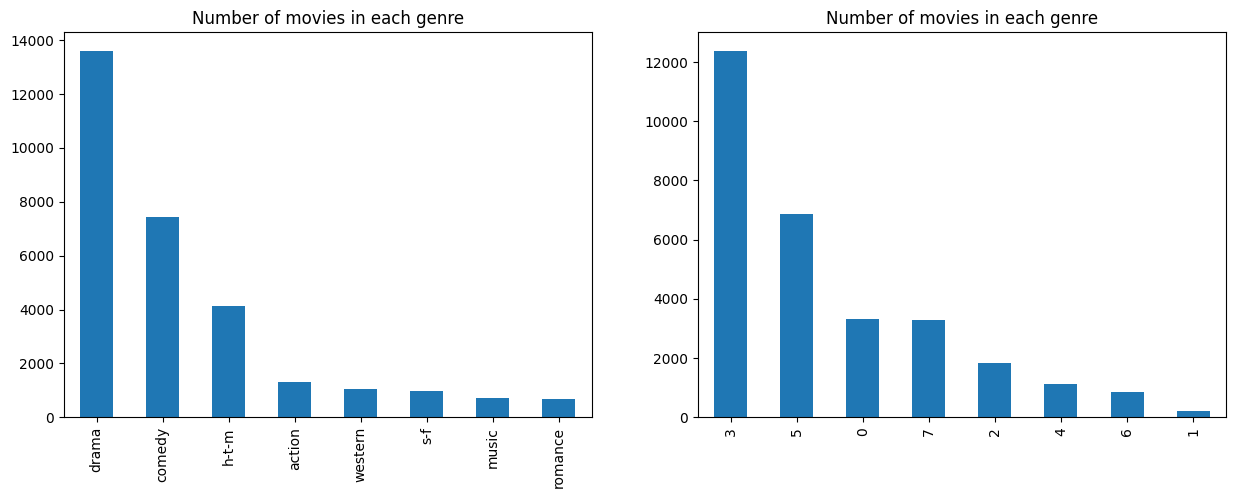

In [24]:
#plot both count plots of genre on top of each other
fig, ax = plt.subplots(1,2, figsize=(15,5))
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[0])
pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[1])
plt.show()

In [25]:
drama_comedy = data[(data['genre'] == 'drama') | (data['genre'] == 'comedy')]


,name,genre,description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
3,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
4,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...
6,In the Gloaming (1997),drama,"Danny, dying of Aids, returns home for his la..."
...,...,...,...
29885,"""Just Not Cool Enough"" (2014)",comedy,"Follow the life of Stephen, a young man just ..."
29886,The Judas Horse (????),drama,After her father is savagely assaulted at the...
29890,Kaçamak (1988),drama,A man and woman meet during the identificatio...
29891,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...


In [16]:
#create a dataframe with y_kmeans
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])
values_counts = pd.Series(y_kmeans).value_counts()
values_counts

3    12387
5     6875
0     3316
7     3270
2     1850
4     1130
6      863
1      203
dtype: int64

In [17]:
#match the predicted genre with the real genre and plot the confusion matrix
real_values = data['genre'].value_counts().sort_values(ascending=False)



NameError: name 'data' is not defined

In [26]:
mapeamento = {7: 'drama', 6: 'comedy', 1: 'action', 4: 'romance', 0: 'h-t-m', 3: 's-f', 5: 'music', 2: 'western'}

y_predicted = [mapeamento[i] for i in y_kmeans]


In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(comedy_drama['genre'], y_predicted)


NameError: name 'accuracy_score' is not defined

In [153]:
sample = data.sample(1)
print("real: ", sample['genre'].values[0])
print("predicted: ", mapeamento[kmeans.predict(X_svd[sample.index])[0]])


real:  drama
predicted:  comedy


In [154]:
#check accurarcy from y_predicted and real_values
from sklearn.metrics import accuracy_score
accuracy_score(data['genre'], y_predicted)


0.22499498227068976

In [155]:
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
Z = hierarchy.linkage(X_svd, method='single')
hierarchy.dendrogram(Z, color_threshold=0.3)

: 

: 

In [46]:
#cluster using gaussian mixture model
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=8, random_state=42)
gmm.fit(X_svd)
y_pred = gmm.predict(X_svd)

y_pred


array([3, 0, 6, ..., 6, 0, 3])

<BarContainer object of 8 artists>

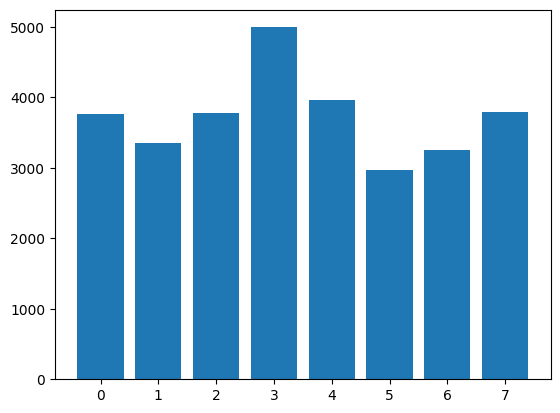

In [48]:
unique, counts = np.unique(y_pred, return_counts=True)

plt.bar(unique, counts)

In [40]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=data['genre'].unique(), yticklabels=data['genre'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

NameError: name 'y_test' is not defined

In [23]:
y_pred = np.load('resultado.npy')


In [81]:

#order data by sum of genres in data['description']
data['genre'].value_counts().sort_values(ascending=False)


drama      13613
comedy      7447
h-t-m       4114
action      1315
western     1032
s-f          970
music        731
romance      672
Name: genre, dtype: int64

<BarContainer object of 8 artists>

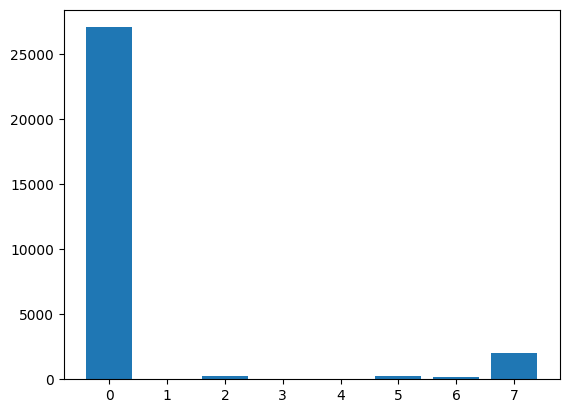

In [38]:
#count unique values of y_pred
unique, counts = np.unique(y_pred, return_counts=True)

plt.bar(unique, counts)


In [20]:
from sklearn.cluster import SpectralClustering

m = SpectralClustering(n_clusters = 8, affinity = 'nearest_neighbors', n_neighbors = 10)
m.fit(X_svd)

y_pred = m.labels_
print("Accuracy: ",accuracy_score(data['genre'], y_pred))


/home/lorenzo/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [39]:
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
Z = hierarchy.linkage(X_svd, method='single')
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, labels=data['genre'], leaf_rotation=90, leaf_font_size=8)
plt.show()



KeyboardInterrupt

